# Test birth-death process simulator

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
import torch
from sbi.utils.torchutils import BoxUniform
from sbi.inference import NPE_C, simulate_for_sbi
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)
import os

os.environ['R_HOME'] = r'C:\Program Files\R\R-4.5.1' # Set local R path
torch_device = "cpu"

Error importing in API mode: ImportError('On Windows, cffi mode "ANY" is only "ABI".')
Trying to import in ABI mode.
c:\Users\u2008181\likelihood-free\sbi_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Simulate observation value

Set the true birth rate to be 3.

In [2]:
simARG = importr("simARG")

robjects.r('set.seed(100)')
x_o = simARG.birth_death_sim2(20, 3.0)
x_o = torch.tensor(x_o, device=torch_device)
x_o = x_o.flatten()

x_o_numpy = x_o.cpu().numpy()

## Prior and simulator

In [3]:
prior = BoxUniform(
    low=torch.tensor([0.0], device=torch_device),
    high=torch.tensor([10.0], device=torch_device), 
    device=torch_device
)

In [4]:
def simulator(theta):
    theta = theta.reshape(-1)
    x_o_R = simARG.birth_death_sim(20, theta.item())
    x_o = list(x_o_R)
    x_o = [item[0] for item in x_o]
    x_o = torch.tensor(x_o, device=torch_device)
    return x_o

In [5]:
from birth_death_sim import birth_death_sim

In [6]:
def simulator(theta):
    theta = theta.reshape(-1)
    x_o = birth_death_sim(20, theta[0].item())
    x_o = torch.tensor(x_o, device=torch_device)
    return x_o

In [8]:
prior, num_parameters, prior_returns_numpy = process_prior(prior)
simulator = process_simulator(simulator, prior, prior_returns_numpy)

In [9]:
check_sbi_inputs(simulator, prior)

## NPE-C

In [10]:
simulation_budget = 10000
seed = 100
num_posterior_samples=1000
learning_rate = 0.0005

inference = NPE_C(prior=prior, density_estimator="nsf", device=torch_device)
torch.manual_seed(seed)
np.random.seed(seed)

In [11]:
theta, x = simulate_for_sbi(
    simulator=simulator, proposal=prior, num_simulations=simulation_budget, num_workers=10
)

100%|██████████| 10000/10000 [00:32<00:00, 311.73it/s]


In [12]:
density_estimator = inference.append_simulations(theta, x).train(
    max_num_epochs=100, learning_rate=learning_rate
)
posterior = inference.build_posterior(density_estimator).set_default_x(x_o)

 Training neural network. Epochs trained: 101

In [13]:
theta_trained = posterior.sample((num_posterior_samples,), x=x_o)
theta_trained = theta_trained.reshape(-1)

1097it [00:00, 35792.42it/s]            


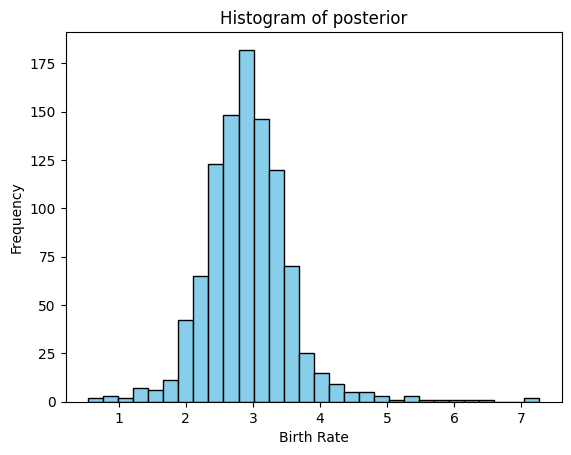

In [14]:
plt.hist(theta_trained.cpu().numpy(), bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Birth Rate')
plt.ylabel('Frequency')
plt.title('Histogram of posterior')
plt.show()